# Importing dependencies and files

In [ ]:
!pip install -U scikit-learn

In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.inspection import permutation_importance

sns.set(style='ticks', context='notebook')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Ensure you have the file `UNSW_NB15_training-set.csv` in your Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_TO_TRAINING_SET = '/MyDrive/AI4ALL/UNSW-NB15/UNSW_NB15_training-set.csv' # Your path for the dataset

In [ ]:
data = pd.read_csv(f'/content/drive/{PATH_TO_TRAINING_SET}')

In [ ]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


# Data Preparation

In [ ]:
data.isnull().sum()

,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


No NULL values, that's great

In [ ]:
data.drop(columns='id', inplace=True) # Don't need ID

## Wireshark Limitations

### Features Wireshark can replicate:
- srcip (Source IP)
- sport (Source port)
- dstip (Destination IP)
- dsport (Destination port)
- proto (Protocol)
- state (TCP flags / connection state)
- sttl (Source-to-destination TTL)
- dttl (Destination-to-source TTL)
- sbytes (Bytes sent by source)
- dbytes (Bytes sent by destination)
- Spkts (Packets from source)
- Dpkts (Packets from destination)
- dur (Flow duration)
- sloss, dloss (Retransmissions / packet loss)
- smeansz, dmeansz (Mean packet sizes)
- Sload, Dload (Bits per second throughput per direction)
- swin / dwin (Advertised TCP window sizes per stream)
- tcprtt, synack, ackdat (TCP handshake timing metrics)
- Sjitm, Djit (Jitter values)
- Sintpkt, Dintpkt (Inter-arrival times)


### Features Wireshark can not replicate
- service (Service type)
- trans_depth, res_bdy_len (HTTP request depth / body size)
- all ct_* features (Flow counts in last 100 connections)
- is_ftp_login (FTP login success flags)
- is_sm_ips_ports (Indicates same-IP/port)

### For this reason, it is best to drop these features since we would not be able to measure these features using Wireshark.

In [ ]:
wireshark_non_scannable = ['service', 'trans_depth', 'response_body_len', 'is_ftp_login', 'is_sm_ips_ports']
ct_features = ['ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_dport_ltm']

wireshark_non_scannable += ct_features

In [ ]:
data.drop(columns=wireshark_non_scannable, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dur         175341 non-null  float64
 1   proto       175341 non-null  object 
 2   state       175341 non-null  object 
 3   spkts       175341 non-null  int64  
 4   dpkts       175341 non-null  int64  
 5   sbytes      175341 non-null  int64  
 6   dbytes      175341 non-null  int64  
 7   rate        175341 non-null  float64
 8   sttl        175341 non-null  int64  
 9   dttl        175341 non-null  int64  
 10  sload       175341 non-null  float64
 11  dload       175341 non-null  float64
 12  sloss       175341 non-null  int64  
 13  dloss       175341 non-null  int64  
 14  sinpkt      175341 non-null  float64
 15  dinpkt      175341 non-null  float64
 16  sjit        175341 non-null  float64
 17  djit        175341 non-null  float64
 18  swin        175341 non-null  int64  
 19  st

There are some features that are non-numeric. Namely `proto`, `state`, `attack_cat`

## Proto Feature Preprocessing

In [ ]:
data['proto'].value_counts()

,count
proto,
tcp,79946
udp,63283
unas,12084
arp,2859
ospf,2595
...,...
argus,98
netblt,98
igmp,18


Since there are many different possible values for this feature, we can use Target Encoding using the frequency for this.

In [ ]:
freq_proto = data['proto'].value_counts(normalize=True)

In [ ]:
data['proto_encoded'] = data['proto'].map(freq_proto)

## State Feature Preprocessing

In [ ]:
freq_state = data['state'].value_counts(normalize=True)
data['state_encoded'] = data['state'].map(freq_state)

## Results with minimal preprocessing



In [ ]:
data.drop(columns=['proto', 'service', 'state'], inplace=True, errors='ignore')

In [ ]:
X = data.drop(columns=['attack_cat', 'label'])
y = data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
round(accuracy_score(y_pred, y_test) * 100, 2)

94.83

In [ ]:
rf.feature_importances_

array([0.02951626, 0.00947782, 0.01362068, 0.0465584 , 0.02727517,
       0.06555493, 0.2322379 , 0.05813656, 0.06985329, 0.08698907,
       0.00848401, 0.00551695, 0.03468694, 0.01438899, 0.01376547,
       0.01490743, 0.00491237, 0.01030247, 0.00973978, 0.00070356,
       0.03601493, 0.0452706 , 0.03462675, 0.03716078, 0.06079477,
       0.0131048 , 0.01639933])

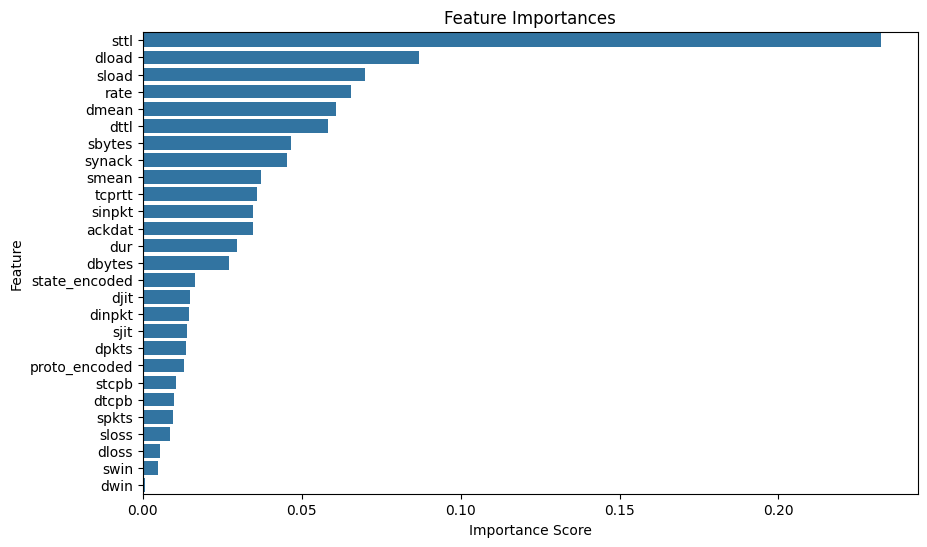

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


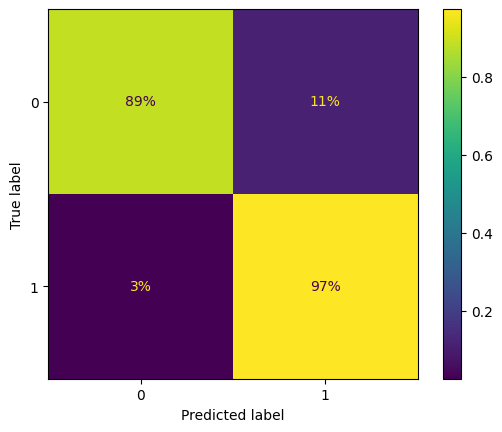

In [ ]:
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')
plt.show()

# Pipeline
Continue from the cleaned `data` above: select features/target, build preprocessing (impute + scale + encode), and create a stratified split for downstream models.

In [ ]:

# Ensure data is available from the earlier steps
assert 'data' in globals(), 'Run the data loading and cleaning cells first.'

TARGET = 'label'
exclude_cols = [TARGET, 'attack_cat']
feature_frame = data.copy()

X = feature_frame.drop(columns=[c for c in exclude_cols if c in feature_frame.columns])
y = feature_frame[TARGET]

print(f'Using {X.shape[1]} features; target positive rate: {y.mean():.3f}')


In [ ]:

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = [c for c in X.columns if c not in categorical_features]

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

transformers = [('numeric', numeric_pipeline, numeric_features)]

if categorical_features:
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ])
    transformers.insert(0, ('categorical', categorical_pipeline, categorical_features))

preprocessor = ColumnTransformer(transformers, remainder='drop')

print(f'Categorical: {categorical_features}')
print(f'Numeric count: {len(numeric_features)}')


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')


# Model
Fit and compare a balanced logistic regression and random forest using the shared preprocessing pipeline.

In [ ]:

log_reg = Pipeline([
    ('preprocess', clone(preprocessor)),
    ('model', LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight='balanced',
    )),
])

rf_clf = Pipeline([
    ('preprocess', clone(preprocessor)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight='balanced',
    )),
])

models = {
    'LogisticRegression': log_reg,
    'RandomForest': rf_clf,
}


In [ ]:

results = []
fitted_models = {}


def evaluate_model(name: str, estimator):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    proba = estimator.predict_proba(X_test) if hasattr(estimator, 'predict_proba') else None

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(y_test, y_pred)

    roc_auc = None
    if proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')
        except ValueError:
            roc_auc = None

    print(f"{name} classification report")
    print(classification_report(y_test, y_pred, zero_division=0))

    results.append({
        'model': name,
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'roc_auc_ovr': roc_auc,
    })
    fitted_models[name] = estimator


for name, est in models.items():
    evaluate_model(name, est)

results_df = pd.DataFrame(results).set_index('model')
display(results_df)

best_name = results_df['f1_weighted'].idxmax()
best_model = fitted_models[best_name]
print(f"Best by weighted F1: {best_name}")

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.show()


# Feature Importance
Inspect the random forest with model-based and permutation importances to see which features drive predictions.

In [ ]:

rf_model = fitted_models.get('RandomForest')
if rf_model is None:
    raise RuntimeError('RandomForest model not fitted. Run the Model cells first.')

rf_estimator = rf_model.named_steps['model']
rf_preprocess = rf_model.named_steps['preprocess']

feature_names = []
if 'categorical' in rf_preprocess.named_transformers_:
    encoder = rf_preprocess.named_transformers_['categorical'].named_steps.get('encoder')
    feature_names.extend(encoder.get_feature_names_out(categorical_features))
if 'numeric' in rf_preprocess.named_transformers_:
    feature_names.extend(numeric_features)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_estimator.feature_importances_,
}).sort_values('importance', ascending=False)

print('Top model-based importances:')
display(importance_df.head(10))

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(top_n), x='importance', y='feature', color='steelblue')
plt.title('RandomForest feature importance (model-based)')
plt.tight_layout()
plt.show()


In [ ]:

perm = permutation_importance(
    fitted_models['RandomForest'],
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

perm_df = pd.DataFrame({
    'feature': feature_names,
    'perm_importance_mean': perm.importances_mean,
    'perm_importance_std': perm.importances_std,
}).sort_values('perm_importance_mean', ascending=False)

print('Top permutation importances (test set):')
display(perm_df.head(10))

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_df.head(top_n),
    x='perm_importance_mean',
    y='feature',
    color='darkorange',
)
plt.title('RandomForest permutation importance (test set)')
plt.tight_layout()
plt.show()
